# Подключение библиотек 

In [60]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kashak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kashak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [61]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import regex as re
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
import parfit.parfit as pf
from wordcloud import WordCloud, STOPWORDS

# Загрузка данных

In [62]:
# В данном случае параметр «./Data/train» указывает на имя папки, в которой будет находиться наша обучающая выборка 
reviews_train = load_files("./Data/train")
text_train, y_train = reviews_train.data, reviews_train.target
df_train = pd.concat((pd.DataFrame(reviews_train.data), 
                     pd.DataFrame(reviews_train.target)), axis=1)
df_train.columns = ['review','target']
df_train['review'] = df_train['review'].astype(str)

In [63]:
# Загрузка тестовых данных 
reviews_test = load_files("./Data/test")
text_test, y_test = reviews_test.data, reviews_test.target
df_test = pd.concat((pd.DataFrame(reviews_test.data), 
                     pd.DataFrame(reviews_test.target)), axis=1)
df_test.columns = ['review','target']
df_test['review'] = df_test['review'].astype(str)

In [64]:
reviews_unsup = load_files("./Data/unsup_t")
text_unsup = reviews_unsup.data
df_unsup = pd.DataFrame(reviews_unsup.data)
df_unsup.columns = ['review']
df_unsup['review'] = df_unsup['review'].astype(str)
df_unsup

,review
0,b'this is a passive movie by ace director anth...
1,"b'""Confusion of Genders"" is all about Alain, a..."
2,"b'I have said, I don\'t how many times, that i..."
3,b'Perhaps the Wagner clan found making it cath...
4,"b""Aviation buffs will love Flight Command. The..."
...,...
49995,"b""I wasn't looking forward to seeing this movi..."
49996,"b""It's the story of a married woman falling in..."
49997,"b""Production house Amicus had a rich tradition..."
49998,b'All the while I was watching this movie I ke...


In [65]:
df_train

,review,target
0,"b""Zero Day leads you to think, even re-think w...",1
1,b'Words can\'t describe how bad this movie is....,0
2,b'Everyone plays their part pretty well in thi...,1
3,b'There are a lot of highly talented filmmaker...,0
4,b'I\'ve just had the evidence that confirmed m...,0
...,...,...
24995,b'089: Footlight Parade (1933) - released 9/30...,1
24996,b'Deeply humorous yet honest comedy about a bu...,1
24997,b'1st watched 2/28/2006 - 4 out of 10(Dir-Sydn...,0
24998,"b""I watch lots of scary movies (or at least th...",0


# Очистка данных

In [75]:
stop_words = stopwords.words('english')
#Удаляем из стоп-слов частицу not, так как она влияет на окраску рецензии
stop_words.remove('not')
stop_words.remove("don't")
lemmatizer = WordNetLemmatizer()

ValueError: list.remove(x): x not in list

In [76]:
def clean_review(review):
    review = re.sub(re.compile('<.*?>'),'',review)
    review = re.sub('[^A-Za-z0-9]+',' ', review)
    review = review.lower()
    
    tokens = nltk.word_tokenize(review)
    
    review = [word for word in tokens if word not in stop_words]
    review = [lemmatizer.lemmatize(word) for word in review]
    
    review = ' '.join(review)
    
    return review

In [77]:
df_train['clean_review'] = df_train['review'].apply(lambda x: clean_review(x))
df_test['clean_review'] = df_test['review'].apply(lambda x: clean_review(x))

In [78]:
df_unsup['clean_review'] = df_unsup['review'].apply(lambda x: clean_review(x))

In [79]:
df_train

,review,target,clean_review
0,"b""Zero Day leads you to think, even re-think w...",1,b zero day lead think even think two boy young...
1,b'Words can\'t describe how bad this movie is....,0,b word describe bad movie explain writing see ...
2,b'Everyone plays their part pretty well in thi...,1,b everyone play part pretty well little nice m...
3,b'There are a lot of highly talented filmmaker...,0,b lot highly talented filmmaker actor germany ...
4,b'I\'ve just had the evidence that confirmed m...,0,b evidence confirmed suspicion bunch kid 14 22...
...,...,...,...
24995,b'089: Footlight Parade (1933) - released 9/30...,1,b 089 footlight parade 1933 released 9 30 1933...
24996,b'Deeply humorous yet honest comedy about a bu...,1,b deeply humorous yet honest comedy bunch grow...
24997,b'1st watched 2/28/2006 - 4 out of 10(Dir-Sydn...,0,b 1st watched 2 28 2006 4 10 dir sydney pollac...
24998,"b""I watch lots of scary movies (or at least th...",0,b watch lot scary movie least try worst not 2n...


# Облако слов 

In [80]:
cv = CountVectorizer()
cv.fit(text_train)

CountVectorizer()

In [81]:
for i,j in zip(df_train['clean_review'], y_train):
    if j == 1:
        str_one_pos = " " + str(i) # формирование одной строки из списка комментариев 
    if j == 0:
        str_one_neg = " " + str(i)   

In [82]:
text_list = list(cv.vocabulary_.keys())
stopwords = set(STOPWORDS)
wordcloud1 = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(str_one_pos) 
wordcloud2 = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords, min_font_size = 10).generate(str_one_neg) 

(-0.5, 799.5, 799.5, -0.5)

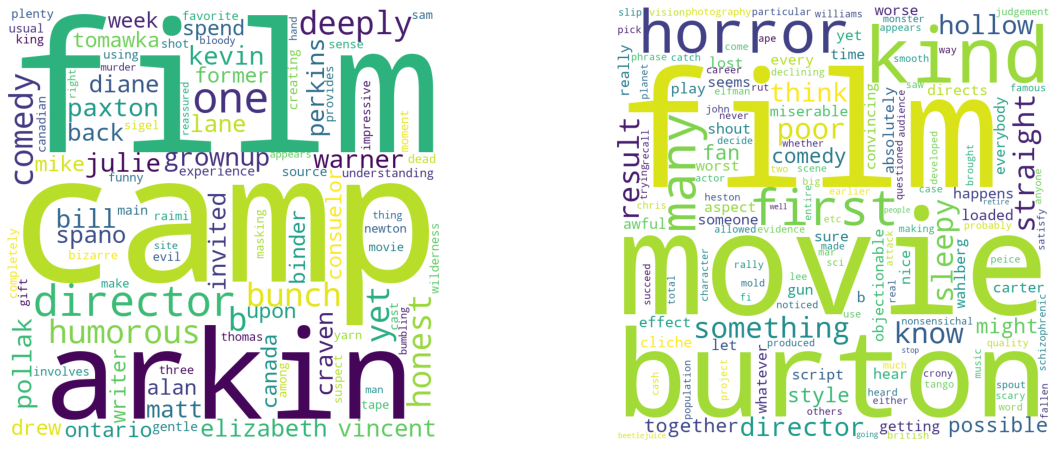

In [83]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.imshow(wordcloud1); ax1.axis("off")
ax2.imshow(wordcloud2); ax2.axis("off")

# Определение базовой модели

Для дальнейшей работы нам необходимо составить словарь уникальных слов, используемых в обучающей выборке. 
Для этого используется метод CountVectorizer

Преобразование соварей текстов в векторную форму 

In [84]:
# BOW
cv = CountVectorizer()
X_train_bow = cv.fit_transform(df_train['clean_review'])
X_test_bow = cv.transform(df_test['clean_review'])
print(X_train_bow.shape)
print(X_test_bow.shape)

(25000, 68458)
(25000, 68458)


In [85]:
# Tfid
tfv = TfidfVectorizer()
X_train_tfid = tfv.fit_transform(df_train['clean_review'])
X_test_tfid = tfv.transform(df_test['clean_review'])
print(X_train_tfid.shape)
print(X_test_tfid.shape)

(25000, 68458)
(25000, 68458)


In [86]:
# Tfid
X_unsup_tfid = tfv.transform(df_unsup['clean_review'])

##  Логистическая регрессия

## BOW

In [87]:
log_reg = LogisticRegression(penalty='l2', random_state=10, max_iter = 1000)
log_reg.fit(X_train_bow, y_train)

LogisticRegression(max_iter=1000, random_state=10)

In [88]:
predicted_log = log_reg.predict(X_test_bow)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_log))

Accuracy:  0.85968


### TF-IDF

In [89]:
log_reg.fit(X_train_tfid, y_train)

LogisticRegression(max_iter=1000, random_state=10)

In [90]:
predicted_log = log_reg.predict(X_test_tfid)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_log))

Accuracy:  0.87996


## K-ближайших соседей

### BOW

In [91]:
knei_class = KNeighborsClassifier(n_neighbors=10)
knei_class.fit(X_train_bow, y_train)

KNeighborsClassifier(n_neighbors=10)

In [92]:
predicted_knei = knei_class.predict(X_test_bow)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_knei))

Accuracy:  0.63116


### TF-IDF

In [93]:
knei_class.fit(X_train_tfid, y_train)

KNeighborsClassifier(n_neighbors=10)

In [94]:
predicted_knei = knei_class.predict(X_test_tfid)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_knei))

Accuracy:  0.6706


## Рандомный лес

### BOW

In [95]:
rf_class = RandomForestClassifier()
rf_class.fit(X_train_bow, y_train)

RandomForestClassifier()

In [96]:
predicted_rf = rf_class.predict(X_test_bow)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_rf))

Accuracy:  0.8516


### TF-IDF

In [97]:
rf_class.fit(X_train_tfid, y_train)

RandomForestClassifier()

In [98]:
predicted_rf  = rf_class.predict(X_test_tfid)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_rf ))

Accuracy:  0.84568


## Наивный байесовский классификатор

### BOW

In [99]:
nb_class = MultinomialNB()
nb_class.fit(X_train_bow, y_train)

MultinomialNB()

In [100]:
predicted_nb = nb_class.predict(X_test_bow)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_nb))

Accuracy:  0.821


### TF-IDF

In [101]:
nb_class.fit(X_train_tfid, y_train)

MultinomialNB()

In [102]:
predicted_nb  = nb_class.predict(X_test_tfid)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_nb))

Accuracy:  0.83064


## Cтохастический градиентный спуск 

### BOW

In [103]:
sgd_class = SGDClassifier(random_state=42, max_iter = 1000)
sgd_class.fit(X_train_bow, y_train)

SGDClassifier(random_state=42)

In [104]:
predicted_sgd = sgd_class.predict(X_test_bow)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_sgd))

Accuracy:  0.8448


### TF-IDF

In [105]:
sgd_class.fit(X_train_tfid, y_train)

SGDClassifier(random_state=42)

In [106]:
predicted_sgd = sgd_class.predict(X_test_tfid)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_sgd))

Accuracy:  0.88004


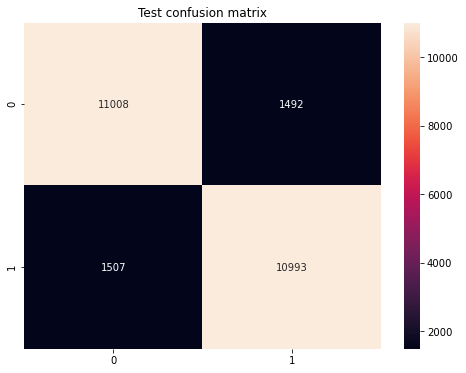

In [107]:
cm = metrics.confusion_matrix(y_test, predicted_sgd)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test confusion matrix')
plt.show()

Таким образом, наилучший результат выдает 

## Улучшение модели

In [108]:
name =['burton','kevin','allan', 'matt', 'elizabeth', 'arkin','mike', 'chris']
stop_words = stop_words + name 

In [109]:
df_train['clean_review'] = df_train['review'].apply(lambda x: clean_review(x))
df_test['clean_review'] = df_test['review'].apply(lambda x: clean_review(x))

In [110]:
tfv = TfidfVectorizer()
X_train_tfid = tfv.fit_transform(df_train['clean_review'])
X_test_tfid = tfv.transform(df_test['clean_review'])
print(X_train_tfid.shape)
print(X_test_tfid.shape)

(25000, 68453)
(25000, 68453)


In [111]:
sgd_class = SGDClassifier( max_iter = 1000, 
                          loss = 'log', penalty = 'l2', 
                          n_jobs = -1, alpha = 1e-4)

In [112]:
sgd_class.fit(X_train_tfid, y_train)

SGDClassifier(loss='log', n_jobs=-1)

In [113]:
predicted_sgd = sgd_class.predict(X_test_tfid)
print("Accuracy: ", metrics.accuracy_score(y_test, predicted_sgd))

Accuracy:  0.87552


Воспользуемся другой бибилиотекой для нахождения оптимального значения альфа

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.1s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.2s finished


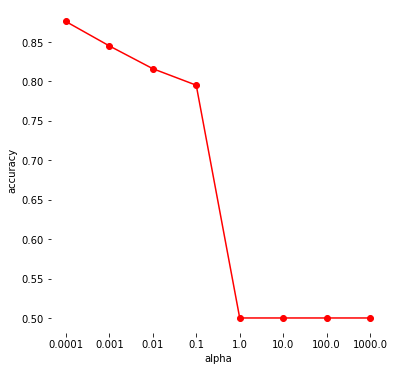

SGDClassifier(loss='log', n_jobs=-1) 0.87612


In [119]:
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = model_selection.ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, 
            paramGrid,
           X_train_tfid, y_train, X_test_tfid, y_test, 
           metric = metrics.accuracy_score,
           scoreLabel = "accuracy")

print(bestModel, bestScore)

In [121]:
grid = {
    'max_iter': [1000], # number of epochs
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = model_selection.ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(LogisticRegression, 
            paramGrid,
           X_train_tfid, y_train, X_test_tfid, y_test, 
           metric = metrics.accuracy_score,
           scoreLabel = "f1_score")

print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished


No parameters that vary in the grid
LogisticRegression(max_iter=1000, n_jobs=-1) 0.88012


In [116]:
predicted_sgd_unsup = sgd_class.predict(X_unsup_tfid)

ValueError: X has 68458 features per sample; expecting 68453

In [ ]:
df_unsup  = pd.concat([df_unsup, pd.DataFrame(predicted_sgd_unsup)], axis=1)
df_unsup

In [58]:
reviews_unsup.data[0]

b'this is a passive movie by ace director anthony minghella, the movie has an awesome star cast and they all give competent performances early in their careers.<br /><br />the movie does not have much of a plot and though the story seems veers to a cliched and predictable end, there are enough minor twists that abound in the movie, making it quite an enjoyable watch. the standout features of the movie include its tight script, terrific lines and smart performances.<br /><br />the plot in itself is no great shakes but this movie is a fun watch for a relaxed evening.<br /><br />an enjoyable and pleasant 7!'